# Preprocessing and clustering

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


The data used in this basic preprocessing and clustering tutorial was collected from bone marrow mononuclear cells of a healthy human donor and was part of Proceedings of the Neural Information Processing Systems Track on Datasets and Benchmarks 1 (NeurIPS Datasets and Benchmarks 2021) (Lücken et al. 2021, A sandbox for prediction and integration of DNA, RNA, and proteins in single cells). The sample used in this tutorial was measured using the 10X Multiome Gene Expression and Chromatin Accessability kit OR 10X 3' Single-Cell Gene Expression kit with Feature Barcoding in combination with the BioLegend TotalSeq B Universal Human Panel v1.0. (!!ToDo adjust after be picked the final sample)


We are reading in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data.

In [3]:
import scanpy as sc, anndata as ad

adatas = {}

for dset in ["s1d1", "s1d3"]:
    sample_adata = sc.read_10x_h5(f"data/basic_scrna_tutorial/{dset}/filtered_feature_bc_matrix.h5")
    sample_adata.var_names_make_unique()
    adatas[dset] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()

reading data/basic_scrna_tutorial/s1d1/filtered_feature_bc_matrix.h5
 (0:00:00)
reading data/basic_scrna_tutorial/s1d3/filtered_feature_bc_matrix.h5


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

The data contains 8,785 cells and 36,601 measured genes. This tutorial includes a basic preprocessing and clustering workflow. 

## Quality Control

The scanpy function `pp.calculate_qc_metrics` calculates common quality control (QC) metrics, which are largely based on `calculateQCMetrics` from scater [McCarthy17]. One can pass specific gene population to `pp.calculate_qc_metrics` in order to calculate proportions of counts for these populations. Mitochondrial, ribosomal and hemoglobin genes are defined by distinct prefixes as listed below. 

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

One can now inspect violin plots of some of the computed QC metrics:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

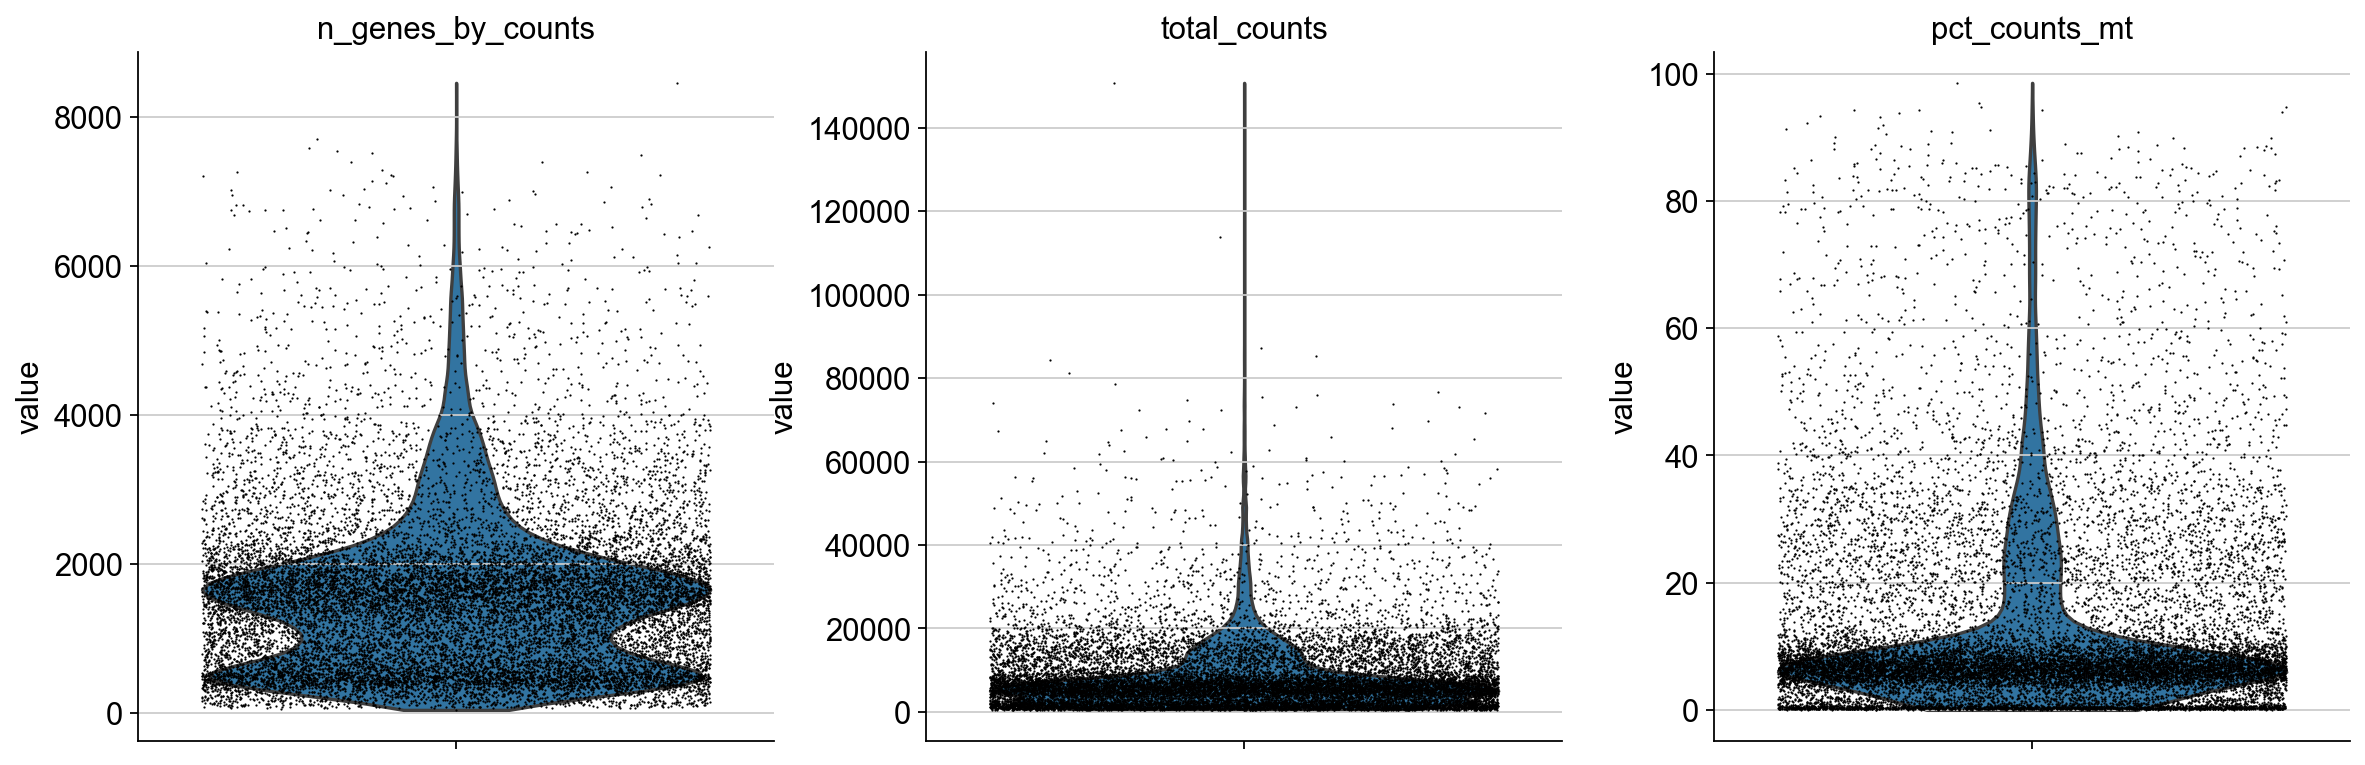

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Additionally, it is useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`. 

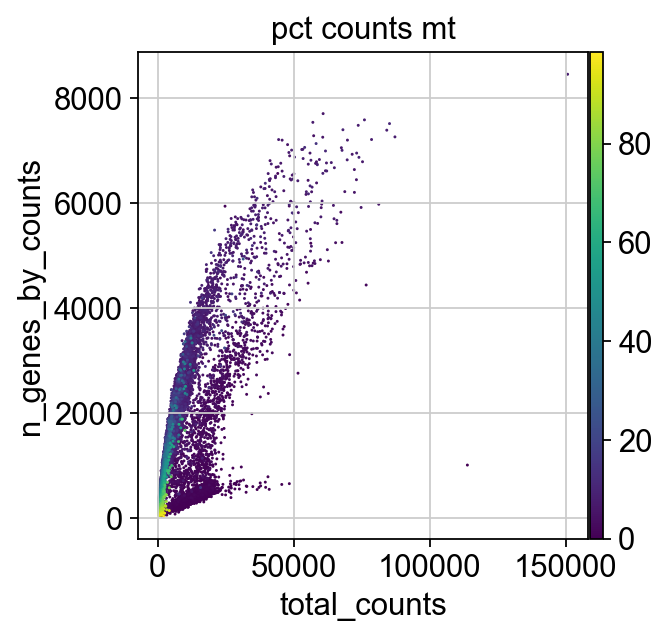

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Based on the QC metric plots, one could now remove cells that have too many mitochondrial genes expressed or too many total counts by setting manual or automatic thresholds. However, it proved to be beneficial to apply a very permissive filtering strategy in the beginning for your single-cell analysis and filter low quality cells during clustering or revisit the filtering again at a later point. We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells. 

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can very substantially between batches. 

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 84 cells that have less than 100 genes expressed
filtered out 13174 genes that are detected in less than 3 cells


### Doublet detection

As a next step, we run a doublet detection algorithm. Identifying doublets is crucial as they can lead to misclassifications or distortions in downstream analysis steps. Scanpy contains the doublet detection method Scrublet [Wolock19]. Scrublet predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes and simulated doublets. `external.pp.scrublet` adds `doublet_score` and `predicted_doublet` to `.obs`. One can now either filter directly on `predicted_doublet` or use the `doublet_score` later during clustering to filter clusters with high doublet scores. 

In [10]:
sc.external.pp.scrublet(
    adata, 
    batch_key='sample'
)

Running Scrublet
filtered out 1752 genes that are detected in less than 3 cells


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 31.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.0%
filtered out 2029 genes that are detected in less than 3 cells


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 4.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.4%
    Scrublet finished (0:00:27)


Alternative methods for doublet detection within the scverse ecosystem are DoubletDetection and SOLO. 

## Normalization

The next preprocessing step is normalization. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via `target_sum` in `pp.normalize_total`. We are applying CPM normalization with log1p transformation in this tutorial. 

In [11]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [12]:
# CPM count depth scaling
sc.pp.normalize_total(adata)
# Logarithmize the data:
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Feature selection

As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function `pp.highly_variable_genes` annotates highly variable genes by reproducing the R-implementations of Seurat [Satija15], Cell Ranger [Zheng17], and Seurat v3 [Stuart19] depending on the chosen `flavor`. 

In [13]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, batch_key='sample'
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


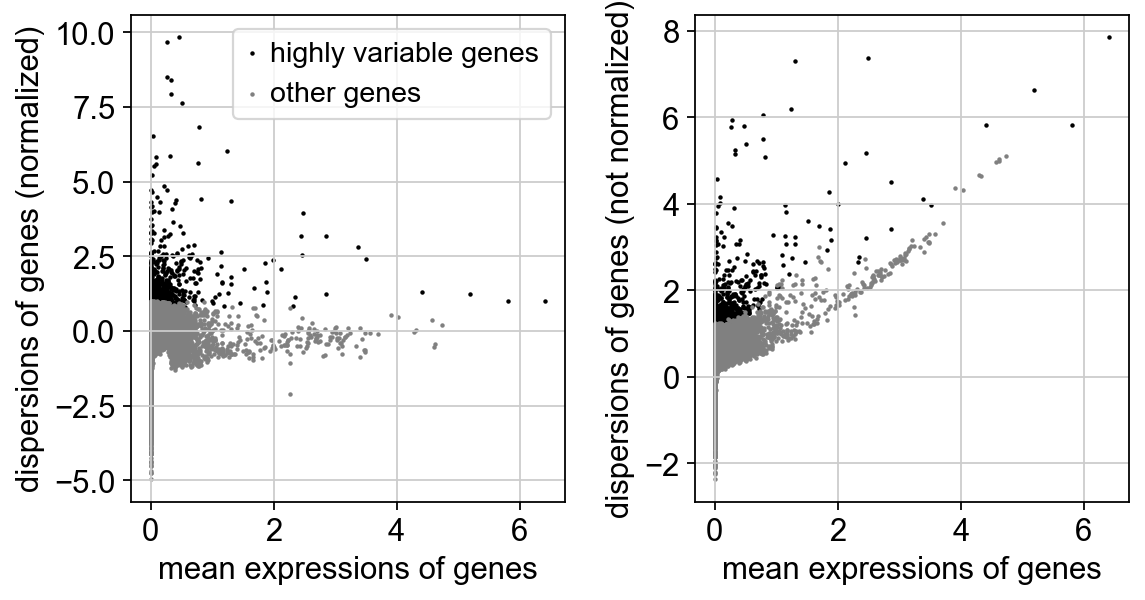

In [14]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [15]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.leiden() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

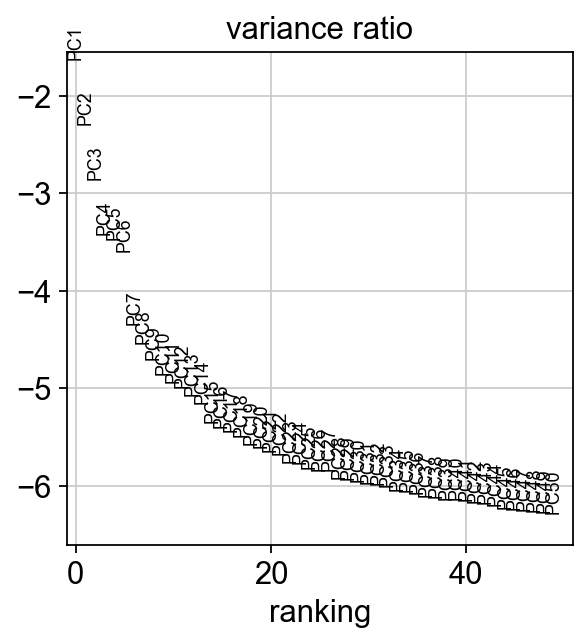

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

## Visualization

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [17]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 

In [18]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


We can now visualize the UMAP according to the `sample`. 

/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


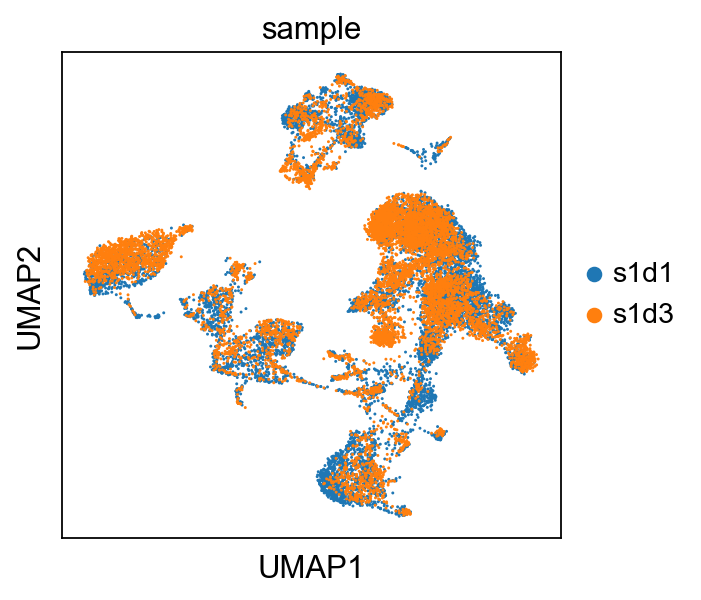

In [19]:
sc.pl.umap(adata, color='sample')

Even though the data considered in this tutorial includes two different samples, we only observe a minor batch effect and we can continue with clustering and annotation of our data. 

If you inspect batch effects in your UMAP it can be beneficial to integrate across samples and perform batch correction/integration. Please check out our advanced tutorial. 

## Clustering

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [20]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


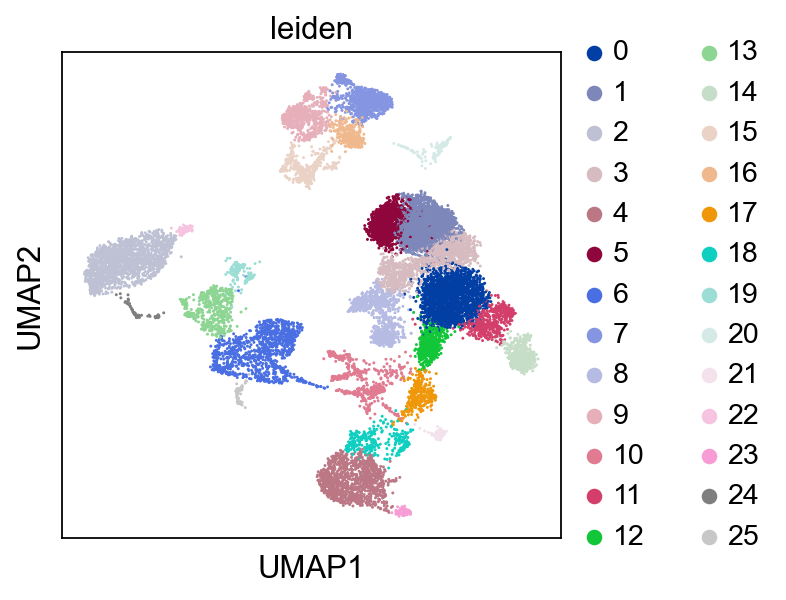

In [21]:
sc.pl.umap(adata, color=['leiden'])

## Re-assess quality control and cell filtering 

As indicated before, we will now re-assess our filtering strategy by visualizing different QC metrics using UMAP. 

/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


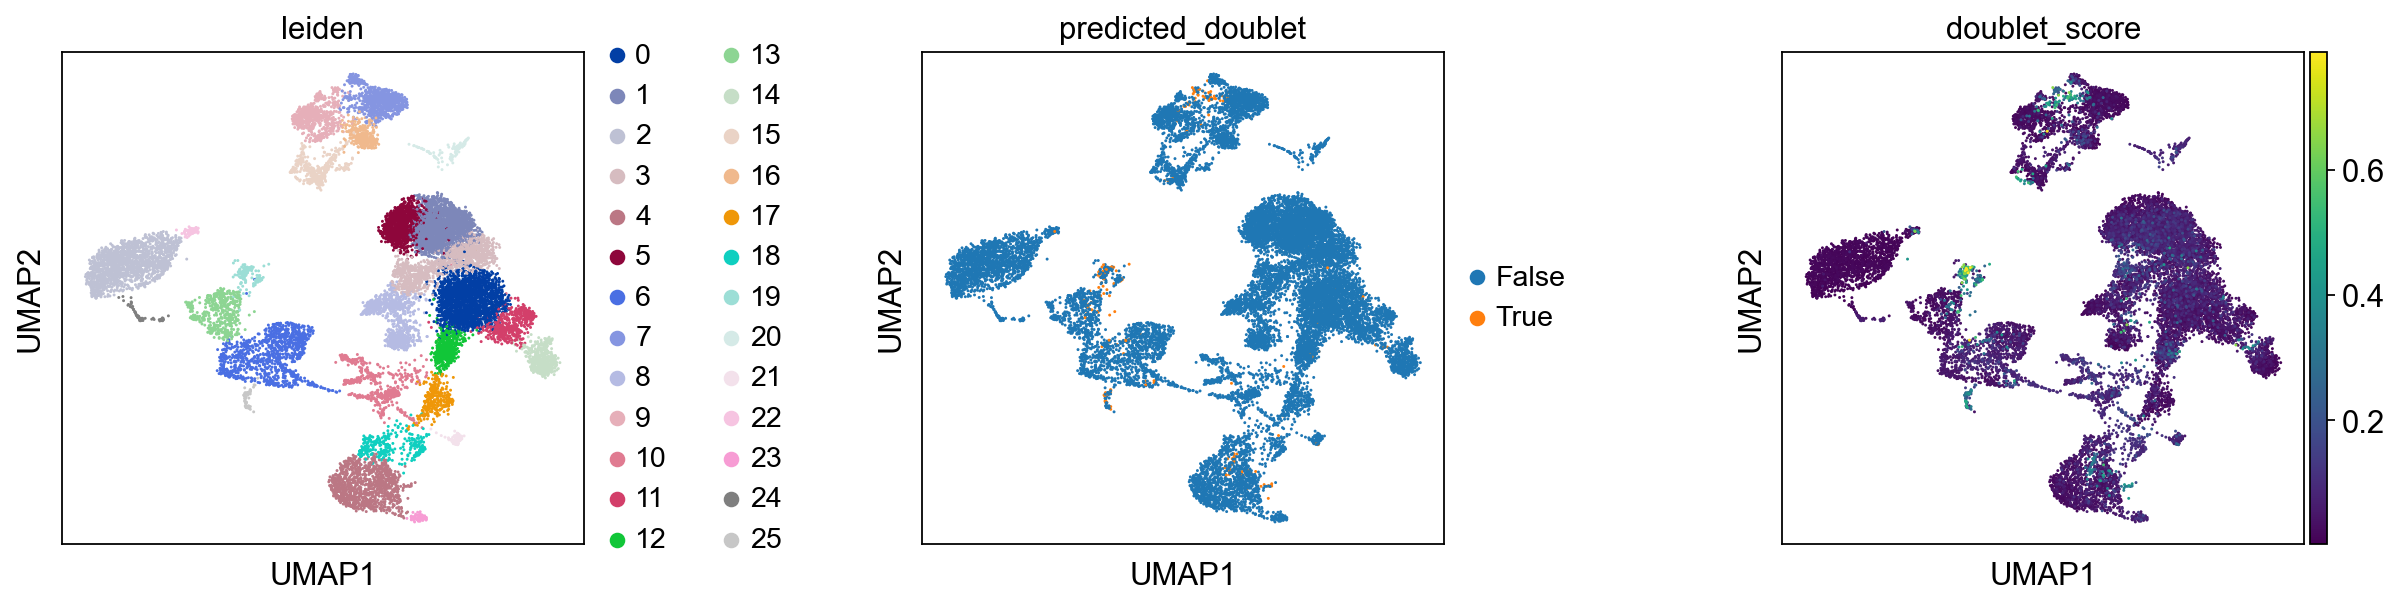

In [22]:
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype('category')
sc.pl.umap(adata, color=['leiden', 'predicted_doublet', 'doublet_score'], wspace=0.5)

The scrublet outputs `doublet_score` and `predicted_doublet` do not form a distinct cluster, we therefore can withdraw from filtering doublets from the dataset and aim to annotate these cells. 

/Users/isaac/miniconda3/envs/new-scanpy-tutorial/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


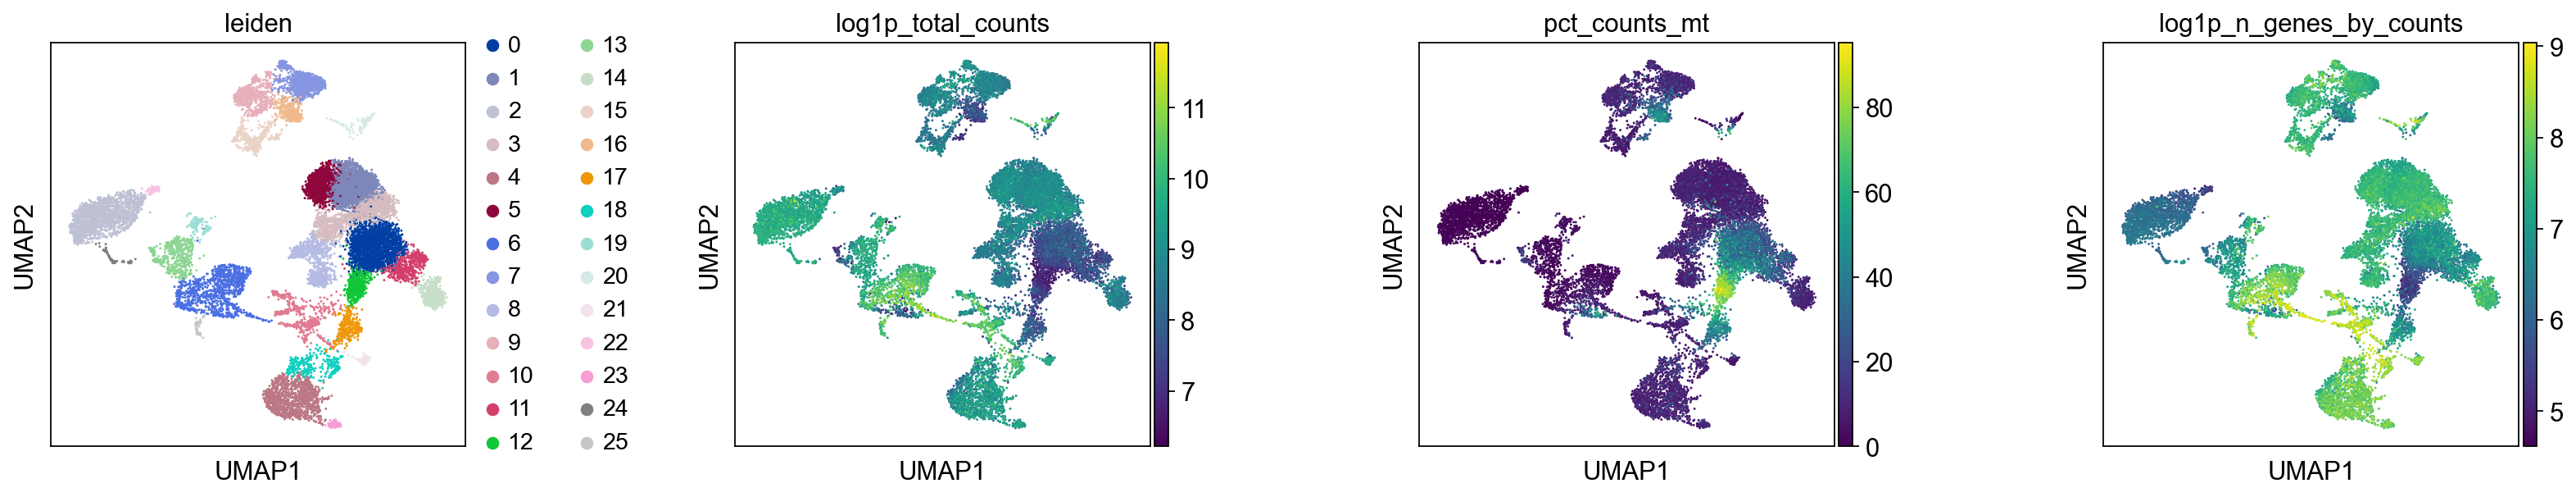

In [23]:
sc.pl.umap(adata, color=['leiden', 'log1p_total_counts', 'pct_counts_mt', 'log1p_n_genes_by_counts'], wspace=0.5)

# Annotation

In [24]:
import decoupler as dc
import seaborn as sns
import celltypist as ct

Taking into consideration that cell clustering is in many ways an arbitrary process, let's define a small set of clustering solutions. Here, we will use leiden to extract cell communities using information from the nearest neighbours graph across a number of different resolutions. 

## Cell types and Prior Knowledge

We have reached a point where we have obtained a good quality set of cells, and we can preceed to their annotation to known cell types. Typically, this is done using genes that are exclusively expressed by specific cell types, or in other words these are the marker genes of the cell types, thus serving to distinguish the heterogeneous groups of cells in our data. 

Previous efforts have collected and curated various marker genes into available resources. In addition to the marker gene collections, there exist approaches to automatically annotate scRNA-seq datasets.

One such tool is [CellTypist](https://github.com/Teichlab/celltypist), which uses gradient-descent optimised logistic regression classifiers to predict cell type annotations.

First, we need to retrive the CellTypist models that we wish to use, in this case we will use models with immune cell type and subtype populations generated using 20 tissues from 18 studies ([Domínguez Conde, et al. 2022](https://www.science.org/doi/full/10.1126/science.abl5197)).

In [25]:
ct.models.download_models(model = ['Immune_All_Low.pkl', 'Immune_All_High.pkl'], force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 18
📂 Storing models in /Users/isaac/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


We then predict the major cell type annotations. In this case we will enable `majority_voting`, which essentially infers the label of each cell independently.

In [26]:
model = ct.models.Model.load(model = 'Immune_All_High.pkl')
predictions = ct.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)
# convert back to anndata||
adata = predictions.to_adata()

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 17041 cells and 23427 genes
🔗 Matching reference genes in the model
🧬 5852 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 122 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:02)


🗳️ Majority voting the predictions
✅ Majority voting done!


Let's examine the results of automatic clustering:

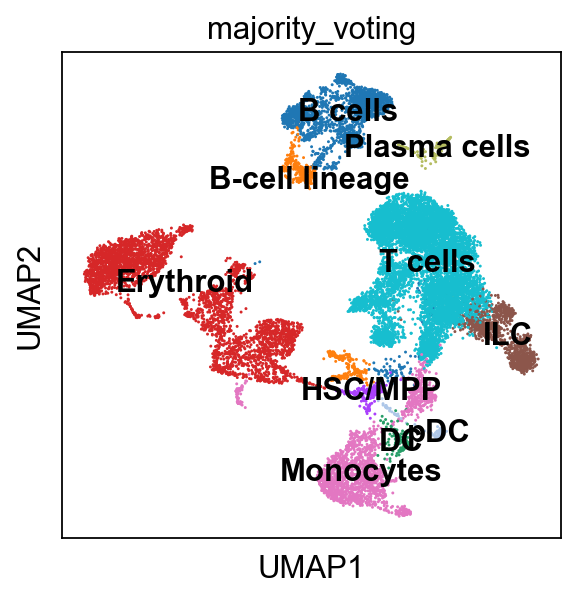

In [27]:
sc.pl.umap(adata, color=['majority_voting'], legend_loc="on data")

These look great, but to confirm that the labels that we got are meaningful, we could double check those against cannoical cell type markers.

Let's get those using with [decoupler](https://github.com/saezlab/decoupler-py) which queries the OmniPath metadata-base to obtain the [PanglaoDB](https://panglaodb.se/) marker gene database with cannonical cell type markers.

In [28]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource(name='PanglaoDB', organism='human')
# Keep canonical cell type markers alone
markers = markers[(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
8,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013


Let's first focus on the main cell types that we obtained via CellTypist, and confirm those with markers with high human specificity:

In [29]:
immune_msk = np.isin(markers.cell_type, ['NK cells', 'T cells', 'B cells'])
specificity_msk = markers['human_specificity'].astype(np.float16) > 0.1
immune_markers = markers[(immune_msk) & (specificity_msk)]

In [30]:
immune_markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
877,S100A4,True,NK cells,Mesoderm,True,0.851351,0.359846,True,0.0,0.0,9606,Immune system,0.098
878,S100A4,True,T cells,Mesoderm,True,0.849802,0.330044,True,0.0,0.0,9606,Immune system,0.098
1181,CD69,True,NK cells,Mesoderm,True,0.527027,0.101347,True,0.0212766,0.00729456,9606,Immune system,0.024
1239,HLA-DRA,True,B cells,Mesoderm,True,0.935484,0.198083,False,0.0,0.0,9606,Immune system,0.039
1246,LTB,True,T cells,Mesoderm,True,0.83004,0.105818,True,0.518692,0.0388394,9606,Immune system,0.065


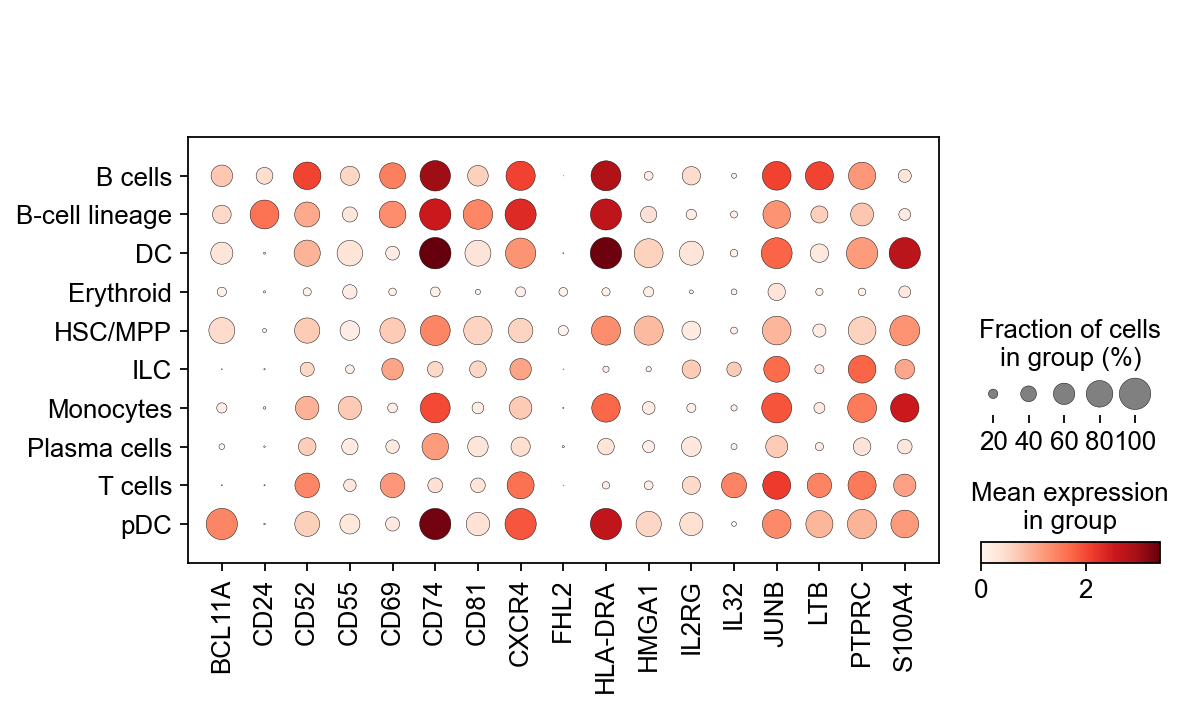

In [31]:
sc.pl.dotplot(adata, np.unique(immune_markers.genesymbol), groupby='majority_voting')

Here, we see that for example the B-cell lineage is clearly distinguishable by the `CD24` marker, which is known to be highly expressed in proliferating B cells. We also see that the `PTPRC` receptor is highly expressed in T cells.

Now that we're confident about the major cell type annotations that we've obtained, we can proceed with labelling our subtypes with the lower resolution immune cell model from `CellTypist`.

In [32]:
# first save the high resolution annotations
adata.obs['majority_voting_high'] = adata.obs['majority_voting'] 

In [33]:
model = ct.models.Model.load(model = 'Immune_All_Low.pkl')
predictions = ct.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)
# transfer the labels alone
adata = predictions.to_adata()

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 17041 cells and 23427 genes
🔗 Matching reference genes in the model
🧬 5852 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 122 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:02)


🗳️ Majority voting the predictions
✅ Majority voting done!


Check the newly obtained subtypes against the higher resolution subtypes.

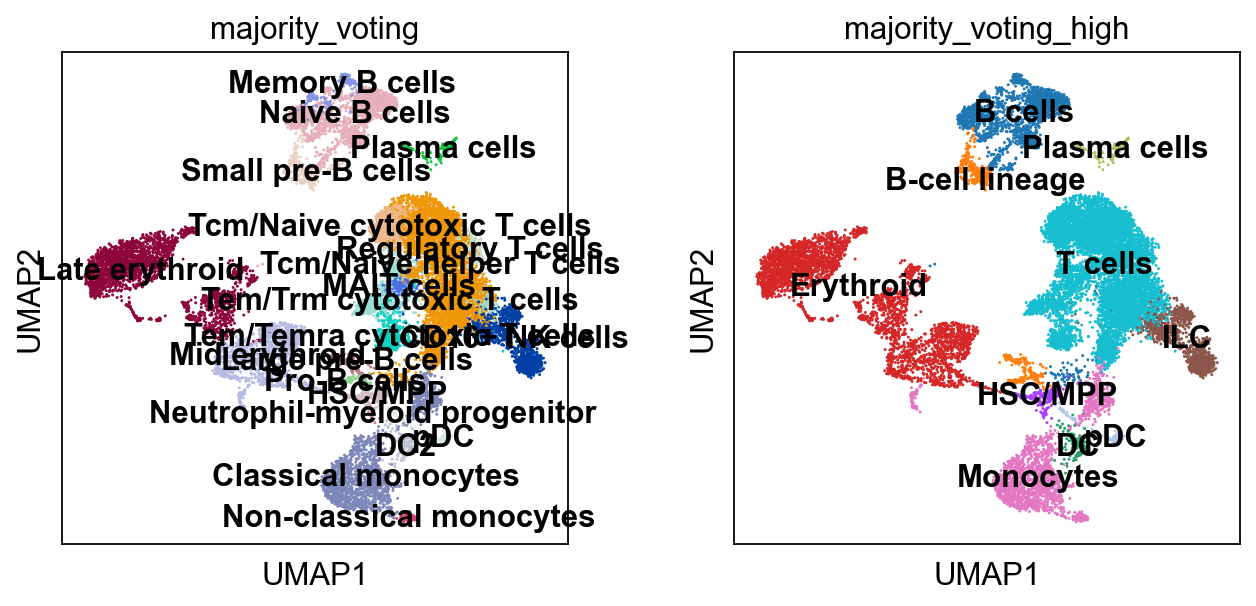

In [34]:
sc.pl.umap(adata, color=['majority_voting', 'majority_voting_high'], legend_loc="on data")

## Clustering-based annotation

Sadly, automatic cell type labelling will not always work so well, as it requires models to be trained that are representitive for a given tissue and the cell types within it. As such, commonly and traditionally, cluster-based clustering has been used to annotate the cell identities to which the cells belong.

So, let's generate a set of clustering solutions which we can then use to annotate our cell types. Here, we will use the Leiden clustering algorithm which will extract cell communities from our nearest neighbours graph.

Notably, here the number of clusters that we define is largely arbitrary, and so is the `resolution` parameter that we used to control for it. As such, the number of clusters is often bound to the biologically-meaningful groups that we can ultimately distringuish, typically done by experts in the corresponding field or by using expert-curated prior knowledge.

In [35]:
sc.tl.leiden(adata, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

running Leiden clustering
    finished: found 5 clusters and added
    'leiden_res0_02', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_res0_5', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden_res2', the cluster labels (adata.obs, categorical) (0:00:01)


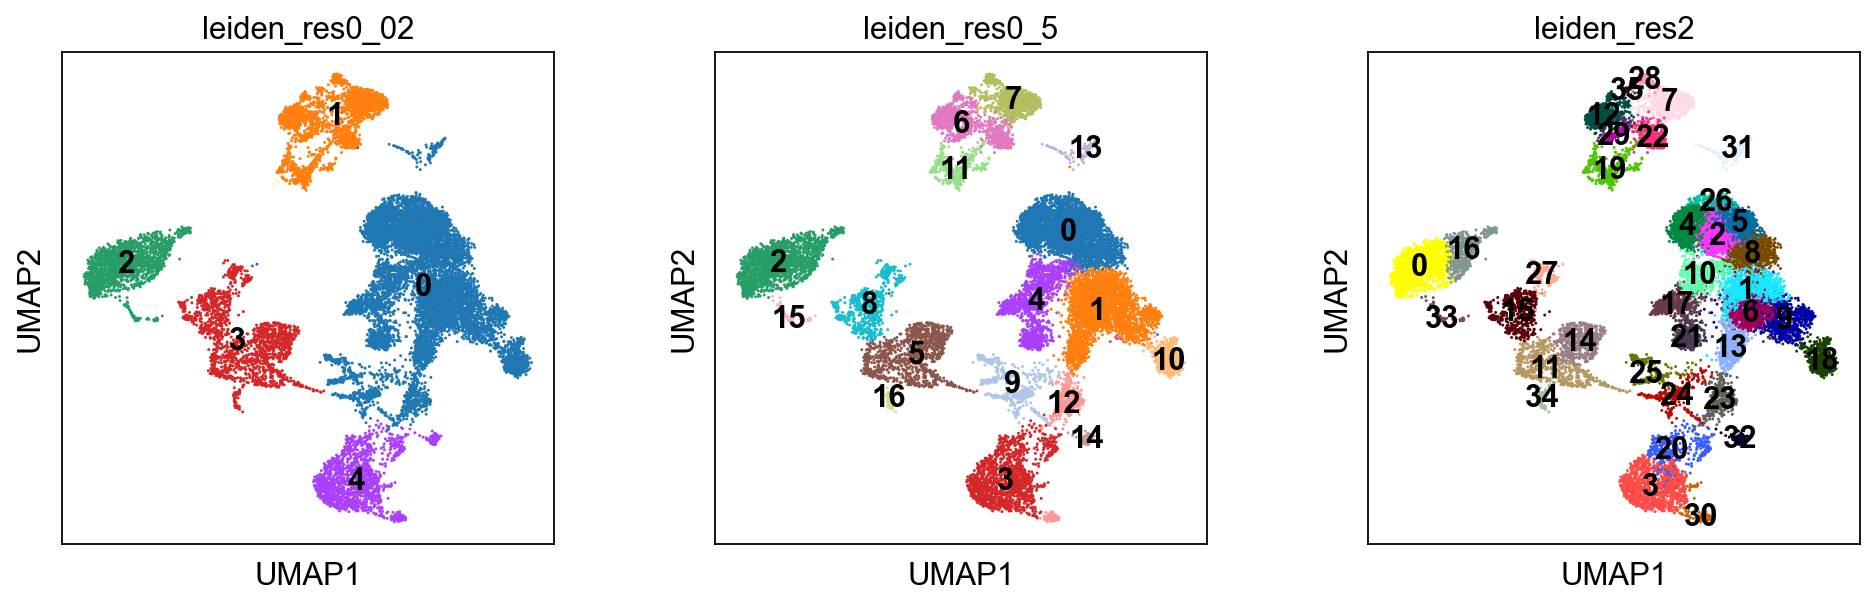

In [36]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

Though UMAPs should not be over-interpreted, here we can already see that perhaps highest resolution is over-clustering our data, or in other words we have too many clusters, while the lowest resolution is likely grouping cells which should be separate.

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden_res0_05', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20)

ranking genes


KeyError: 'leiden_res0_05'

### Annotation with over-representation analysis 

To annotate the cells, we will use **PanglaoDB** with simple over-representation analysis (ORA), also known as one-sided Fisher exact test, via **decoupler**. In reality, this will simply test if any collection of genes are over-represented in any of the cells.

This process can also be done with many other available approaches. >> link to book?

For this example, we will use [PanglaoDB](https://academic.oup.com/database/article/doi/10.1093/database/baz046/5427041), but any other collection of genes could be used.

In [ ]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=5, verbose=True)

The obtained ORA results are stored in the .obsm key, with ora_estimate representing -log10(pvals):

In [ ]:
adata.obsm['ora_estimate'].head()

#### Visualize

To visualize the obtianed scores, we can re-use any of scanpy’s plotting functions. 
First though, we will extract them from the adata object.

In [ ]:
acts = dc.get_acts(adata=adata, obsm_key='ora_estimate')
sc.pp.scale(acts)

In [ ]:
sc.pl.umap(acts, color=['NK cells', 'B cells', 'T cells',
                        'Erythroid-like and erythroid precursor cells'])

Here, we can clearly see that our approach highlighted several clusters of NK, B, and T cells.

We can then further summarize our over-representation results into the clustering annotations that we defined earlier, starting with the one with the highest resolution.
We will focus only on those cell type annotations enough variability across the cells (standard deviation > 1.5), as a way to exclude the non-informative annotations.

In [ ]:
mean_ora = dc.summarize_acts(acts, groupby='leiden_res0_5', min_std=1.0)

In [ ]:
sns.clustermap(mean_ora, xticklabels=mean_ora.columns, cmap='viridis')

Here, we can see that while some cell types are clearly separated. However, we can also see that some of the clusters, such as `3` and `6`, can be further separated into multiple cell types. As such, we should attempt to separate those with the higher resolution solutions.

Let's try with the `leiden_res2` labels which represent leiden clustering with a `resolution` param of 2.

In [ ]:
mean_ora = dc.summarize_acts(acts, groupby='leiden_res2', min_std=1.0)

In [ ]:
sns.clustermap(mean_ora, xticklabels=mean_ora.columns, cmap='viridis', figsize=(10,13))

In this case, we can see that perhaps the specified resolution is too high to distinguish the different clusters into cell types, this could perhaps be due to our releatively low number of cells, or due to the relatively coarse annotation in the database that we're using. Either way, we should perhaps use a more moderate clustering solution. 

So let's finally try with the `leiden_res0_5` labels.

In [ ]:
mean_ora = dc.summarize_acts(acts, groupby='leiden_res0_5', min_std=1.0)

In [ ]:
sns.clustermap(mean_ora, xticklabels=mean_ora.columns, cmap='viridis')

This seems like a relatively good solution, so let's stick to it.

///// We see that B cells are clearly sep into 3 subtypes, x belong to y, etc, etc, extend description with Anna's data.
Nevertheless, we see that some clusters e.g. T cells should be further subclustered.

In [ ]:
annotation_dict = dc.assign_groups(mean_ora)
annotation_dict

In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type2'] = [annotation_dict[clust] for clust in adata.obs['leiden_res0_5']]

In [ ]:
sc.pl.umap(adata, color=['cell_type', 'leiden_res0_5'], legend_loc="on data")

In [ ]:
# quick ref to original clustering
sc.pl.umap(adata, color='cell_type', legend_loc="on data")

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden_res0_5', method='t-test')

In [ ]:
marker_genes = []
for x in adata.obs['leiden_res0_5'].cat.categories: 
    marker_genes.append(sc.get.rank_genes_groups_df(adata=adata, group=x).head(5).names)

In [ ]:
marker_genes = np.unique(marker_genes)

In [ ]:
marker_genes

Additionally, we inspect `total_counts`, `pct_counts_mt`and `n_genes_by_counts`. Leiden cluster 7 and 11 indicate cells with a relatively high fraction of mitochondrial counts, which can be an indicator for broken membranes. 

Cluster 13 shows cells with a high number of genes by counts. These cells can be more challenging to annotate and it might be reasonable to filter them out. 

Based on these plots, one can now define manual thresholds for `total_counts`, `pct_counts_mt`and `n_genes_by_counts`, revisit the quality control preprocessing step and re-run the subsequent analysis steps. 